# Monte-Carlo-Simulation
© Thomas Robert Holy 2019
<br>
Version 1.1.3
<br><br>
Visit me on GitHub: https://github.com/trh0ly
## Grundlegende Einstellungen:
Zunächst müssen die notwendigen Pakete (auch Module) importiert werden, damit auf diese zugegriffen werden kann. 

In [1]:
import pandas as pd # Programmbibliothek die Hilfsmittel für die Verwaltung von Daten und deren Analyse anbietet
import scipy.stats as st # SciPy ist ein Python-basiertes Ökosystem für Open-Source-Software für Mathematik, Naturwissenschaften und Ingenieurwissenschaften
from scipy.stats import rankdata, norm  
from scipy import array, linalg, dot
import random # Dieses Modul wird verwendet um Zufallszahlen zu ziehen
import numpy as np # Programmbibliothek die eine einfache Handhabung von Vektoren, Matrizen oder generell großen mehrdimensionalen Arrays ermöglicht
import math # Dieses Modul wird verwendet um Skalardaten zu berechnen, z. B. trigonometrische Berechnungen.
import operator # Programmbibliothek, welche die Ausgaben übersichtlicher gestaltet
import matplotlib.pyplot as plt # Programmbibliothek die es erlaubt mathematische Darstellungen aller Art anzufertigen
import matplotlib.patches as mpatches
from riskmeasure_module import risk_measure as rm
from IPython.core.display import display, HTML

Anschließend werden Einstellungen definiert, die die Formatierung der Ausgaben betreffen.
Hierfür wird das Modul `operator` genutzt.
Außerdem wird die Größe der Grafiken modifiziert, welche später angezeigt werden sollen.

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
display(HTML("<style>.container { width:100% !important; }</style>"))
SCREEN_WIDTH = 115
centered = operator.methodcaller('center', SCREEN_WIDTH)
plt.rcParams["figure.figsize"] = 15,15

## Monte-Carlo Simulation:
### Variablen spezifizieren
Im ersten Schritt werden die für die Simulation notwenigen Variablen definiert.

In [4]:
##########################################################################
#-------------------------------------------------------------------------
# Anzahl Simulationsdurchläufe
n = 10000

#----------------------------------------------------
# Neue Randverteilungen (Gleichverteilung)
rand_x = [10,20]
rand_y = [8,22]

#----------------------------------------------------
# Varianzen und Korrelation(en)
var_x = 4 
var_y = 9

corr_list = [0]
std_list = [math.sqrt(var_x), math.sqrt(var_y)]

#----------------------------------------------------
# Erwartungswerte
mu = [2, 3]
#-------------------------------------------------------------------------
##########################################################################

### Funktionen definieren
Als nächstes werden Funktionen definiert. Die erste Funktion berechnet aus den gegeben Varianzen und dazugehörigen Korrelationen die Varianz-Kovarianz-Matrix, die Zweite legt ein Array mit den gegebenen Varianzen an und die Dritte führt die Cholesky-Zerlegung auf der Grundlage Varianz-Kovarianz-Matrix durch. 
Die weiteren Funktionen vereinfachen das Plotten.

In [5]:
#---------------------------------------------------------------------------------------------------------------
# Definition einer Funktion, welche eine Varianz-Kovarianz-Matrix erstellt
# Argumente:
# - std_list: Liste mit Standardabweichungen
# - corr_list: Liste mit Korrelationskoeffizienten
#------------
def var_covar_matrix_func(std_list, corr_list):    
    counter_0, counter_1 = 0, 0
    len_std_list = len(std_list)
    array = [[0] * len_std_list] * len_std_list    
    val_list = []
    
    # Für jedes i und j in len_std_list..
    for i in range(0,len_std_list):
        for j in range(0,len_std_list):
            # Wenn i = j, dann multipliziere beide Werte
            if i == j:
                val = std_list[i] * std_list[i]
                val_list.append(val)
            # Wenn i kleiner j, dann multipliziere beide Standardabweichungen
            # und die dazugehörige Korrelation
            if i < j:
                val = (std_list[i] * std_list[j] * corr_list[counter_0])
                counter_0 += 1
                val_list.append(val)
            # Wenn i größer j, dann multipliziere beide Standardabweichungen
            # und die dazugehörige Korrelation
            if i > j:
                val = (std_list[i] * std_list[j] * corr_list[counter_1])
                counter_1 += 1
                val_list.append(val)
                
    var_covar = np.array(val_list).reshape(len_std_list, len_std_list)      
    return var_covar
    
#---------------------------------------------------------------------------------------------------------------
# Definition einer Funktion, welche ein Varianz-Array erstellt
# Argumente:
# - std_list: Liste mit Standardabweichungen
#------------
def var_func(std_list):    
    var_list = []    
    for i in range(0, len(std_list)):
        var = np.power(std_list[i],2)
        var_list.append(var)        
    return var_list

#---------------------------------------------------------------------------------------------------------------
# Definition einer Funktion, welche die Cholesky-Zerlegung durchführt
# Argumente:
# - var_covar: Varianz-Kovarianz-Array
#------------
def cholesky_func(var_covar):    
    # Leere Matrix anlegen
    lower = [[0 for x in range(len(var_covar))]  
                for y in range(len(var_covar))]
  
    # Zerlegt eine Matrix in unter Dreiecksmatrix
    # und deren transponierte Matrix
    for i in range(len(var_covar)):  
        for j in range(i + 1):  
            sum1 = 0  
            # Diagonale
            if j == i:  
                for k in range(j): 
                    sum1 += pow(lower[j][k], 2) 
                lower[j][j] = int(math.sqrt(var_covar[j][j] - sum1)) 
            # Nicht-Diagonale    
            else:                   
                # Bestimmung L(i, j) durch Nutzung Formel für L(j, j) 
                for k in range(j): 
                    sum1 += (lower[i][k] * lower[j][k])
                if(lower[j][j] > 0): 
                    lower[i][j] = int((var_covar[i][j] - sum1) / lower[j][j]) 
                    
    # Transformation in ein Numpy-Array und Rückgabe
    lower = np.array(lower)
    return lower
#---------------------------------------------------------------------------------------------------------------
# Hilfsfunktionen zum Plotten

#---------------------------
# Definition einer Funktion, welche eine gegebene Liste mit 2er-Tuples in X- und Y-Realisationen splittet
# Argumente:
# - liste: Liste mit 2er-Tuple
#------------
def split_liste(liste):     
    counter = 0
    x_liste, y_liste = [], []
    
    for i in range(0, len(liste)):
        x = liste[counter][0]
        y = liste[counter][1]
        x_liste.append(x)
        y_liste.append(y)
        counter += 1        
    return x_liste, y_liste

#---------------------------
# Definition einer Funktion, welche die Grafiken plottet
# Argumente:
# - x_liste: x-Realisationen
# - y_liste:y-Realisationen
# - show:
# --> Wenn True: Grafik wird unmittelbar darstellt
# --> Wenn False: Grafik wird nicht unmittelbar darstellt
# - get_xy_lim:
# --> Wenn True: X- und Y- Kooridnaten werden ermittelt und die Grafik wird darauf begrenzt
# --> Wenn False: Keine Anpassung der Koordinatenachsen
#------------
def plot_func(x_liste, y_liste, show=True, get_xy_lim=True):
    plt.scatter(x_liste, y_liste)
    
    if get_xy_lim == True:    
        left, right = plt.xlim()
        plt.xlim((left, right))   
        plt.xlim(left, right)     
        left, right = plt.ylim()
        plt.ylim((left, right)) 
        plt.ylim(left, right)   
        
    plt.grid()
    plt.xlabel('Realisation X')
    plt.ylabel('Realisation Y')
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
        
    if show == True:
        plt.show()

#---------------------------       
# Definition einer Funktion, ein Histogramm plottet
#------------        
def hist_func(H, X1):
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H) * dx
    plt.plot(X1[1:], F1)

#---------------------------
# Definition einer Funktion, welche eine Verteilungsfunktion plottet
#------------    
def verteilung_func():
    plt.title('Verteilung X+Y, Realisationen gleichverteilte X,Y mit Gauss-Copula')
    blue_patch = mpatches.Patch(color='blue', label='Monte-Carlo-Simulation(en)')
    plt.legend(handles=[blue_patch], loc='upper left')
    plt.grid()
    plt.xlabel('PF-Realisation')
    plt.ylabel('Wahrscheinlichkeit')
    left, right = plt.xlim()
    plt.xlim((left, right))
    plt.xlim(left, right)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.show()

### Funktion für die Monte-Carlo-Simulation definieren
Nun wird eine Funktion definiert, in welcher die Simulation durchgeführt wird. 
Dabei werden zunächst zwei gleichverteilte Pseudo-Zufallszahlen generiert, welche anschließend in unabhängige standardnormalverteilte Zufallszahlen transformiert werden.
Letztere werden unter Anwendung der Cholesky-Zerlegung in abhängige standardnormalverteilte Zufallszahlen überführt.
Danach werden diese unter Anwendung der oben gegebenen Standardabweichungen und der gegebenen Erwartungswerte in Realisationen der Gauss-Copula überführt, bevor auf diese anschließend die neuen Randverteilungen angewendet werden.
Zum Schluss wird die Summe aus beiden Realisationen gebildet, welche den Portfolio-Wert ergibt.

In [6]:
# Definition einer Funktion, welche die Monte-Carlo-Sumulation durchführt
# Argumente:
# - simulation_runs: Anzahl an Durchläufen der Simulation
# - randverteilung_x: Neue Randverteilung der Variablen X
# - randverteilung_y: Neue Randverteilung der Variablen Y
# - mu_list: Liste mit Erwartungswerten
# - std_list: Liste mit Standardabweichungen
# - corr_list: Liste mit Korrelationen
# - m: Anzahl der Variablen die pro Lauf gezogen werden (hier gerade nur zwei möglich)
# - full_log:
# --> Wenn True: Alle berechneten Größen werden den Listen angefügt
# --> Wenn False: Nur die Summe (das letztendliche Ergebnis der Simulation) der Realisationen wird einer Liste angefügt
#------------
def copula_sim(simulation_runs, randverteilung_x, randverteilung_y, mu_list, std_list, corr_list, m=2, full_log=False):
    
    # Listen für die zu berechnenden Größen
    total_standard_norm_ab_list, total_realisation_cop_list = [], []
    total_xy_list, total_summe_liste = [], []
    
    # Funktionen aufrufen um die für die folgenden Berechnungen nötige Werte zu erhalten
    var_covar = var_covar_matrix_func(std_list, corr_list)
    var_list = var_func(std_list)
    cholesky = cholesky_func(var_covar)
    
    # Durchführung der n Durchläufe
    for i in range(0, simulation_runs):        
        #---------------------------------------------------------------------------------------------------------------
        # Gleichverteilte Zufallszahlen ziehen        
        random_ZV_list = []  
        for i in range(0, m):
            x = random.random()
            random_ZV_list.append(x)
        if simulation_runs == 1:
            print('1) Gleichverteilte Zufallszahlen: {}\n'.format(random_ZV_list))
        
        #---------------------------------------------------------------------------------------------------------------
        # Transformation der gleichverteilten Zufallszahlen in unabhängige standardnormalverteilte Zufallszahlen
        standard_norm_list = norm.ppf(random_ZV_list)   
        if simulation_runs == 1:
            print('2) Standardnormalverteilte Zufallszahlen: {}\n'.format(standard_norm_list))
        
        #---------------------------------------------------------------------------------------------------------------
        # Transformation in standardnormalverteilte abhängige Zufallszahlen        
        standard_norm_ab_list = []
        counter_cholesky_0, counter_cholesky_1 = 0, 0
        counter_mu, counter_standard_norm_list = 0, 0

        # Für jede zuvor gezogene unabhängige, standardnormalverteilte Zufallszahlen 
        # wird die Abhänigkeitsstruktur (aus der Cholesky-Matrix) auf diese Zufallszahlen übertragen
        for i in range(0, m):
            # 1. Schritt: Berechnung a, mit a = 1. unabhängige standardnormalverteilte Zufallsvariable * Eintrag in Cholesky-Matrix
            a = cholesky[counter_cholesky_0][counter_cholesky_1] * standard_norm_list[counter_standard_norm_list]
            counter_cholesky_1 += 1
            counter_standard_norm_list += 1

            # 2. Schritt: Berechnung b, mit b = 2. unabhängige standardnormalverteilte Zufallsvariable * Eintrag in Cholesky-Matrix
            b = cholesky[counter_cholesky_0][counter_cholesky_1] * standard_norm_list[counter_standard_norm_list]
            counter_cholesky_0 += 1  
            counter_cholesky_1 = 0
            counter_standard_norm_list = 0  

            # 3. Schritt: Endergebnis r ist der Erwartungswert + a + b und stellt die abhängige standardnormalverteilte Zufallsvariable dar
            r = a + b + mu_list[counter_mu]
            standard_norm_ab_list.append(r)
            counter_mu += 1
        if simulation_runs == 1:
            print('3) Standardnormalverteilte abhängige Zufallszahlen: {}\n'.format(standard_norm_ab_list))

        #---------------------------------------------------------------------------------------------------------------
        # Transformation Realisationen der Gauss-Copula
        counter = 0
        realisation_cop_list = []     
        # Transformation indem von jeweiliger abhängiger standardnormalverteilter Zufallszahlen
        # der dazugehörige Erwartungswert subtrahiert wird, und dieses Ergebnis dann durch die dazugehörige Standardabweichung geteilt wird
        # Die Realisation der Gauss-Copula ergibt sich dann als der Wert (Wahrscheinlichkeit) der kumulierten Normalverteilungsfunktion
        for i in range(0, m):
            r_cop = (standard_norm_ab_list[counter] - mu_list[counter]) / math.sqrt(var_list[counter])   
            p_value = st.norm.cdf(r_cop)
            realisation_cop_list.append(p_value)
            counter += 1
        if simulation_runs == 1:
            print('4) Realisationen der Gauss-Copula: {}\n'.format(realisation_cop_list))
            
        #---------------------------------------------------------------------------------------------------------------
        # Gemeinsame Verteilung: Übertragung der neuen Ränder auf die ermittelte Abhängigkeitsstruktur  
        # Für x und y wird jeweils (Obergrenze - Untergrenze) * Realisation der Gauss-Copula + Untergrenze gerechnet
        # Dabei sind Obergrenze bzw. Untergrenze der linke bzw. rechte Rand des Intervalls der neuen Randverteilungen
        x = (randverteilung_x[0] - randverteilung_x[1]) * realisation_cop_list[0] + randverteilung_x[1]
        y = (randverteilung_y[0] - randverteilung_y[1]) * realisation_cop_list[1] + randverteilung_y[1]
        
        # Die Summe bzw. das Endergebnis der Simulation ist dann X + Y, also die gemeinsame Realisation
        summe = x + y 
        if simulation_runs == 1:
            print('5) Sumulationsergebnisse: x={}, y={}, Summe={}'.format(x, y, summe))
        
        # Berechnete Werte werden den jeweiligen Listen angefügt
        if full_log == True:
            total_standard_norm_ab_list.append(standard_norm_ab_list)
            total_realisation_cop_list.append(realisation_cop_list)
            total_xy_list.append((x, y))
        total_summe_liste.append(summe)        
  
    return total_standard_norm_ab_list, total_realisation_cop_list, total_xy_list, total_summe_liste

In [7]:
_, _, _, _ = copula_sim(1, rand_x, rand_y, mu, std_list, corr_list, full_log=False)

1) Gleichverteilte Zufallszahlen: [0.6875589121580646, 0.9019239856196092]

2) Standardnormalverteilte Zufallszahlen: [0.48894282 1.29259252]

3) Standardnormalverteilte abhängige Zufallszahlen: [2.9778856499716673, 6.877777553550164]

4) Realisationen der Gauss-Copula: [0.6875589121580648, 0.9019239856196091]

5) Sumulationsergebnisse: x=13.124410878419352, y=9.373064201325473, Summe=22.497475079744824


In [8]:
total_standard_norm_ab_list, total_realisation_cop_list, total_xy_list, total_summe_liste = copula_sim(n, rand_x, rand_y, mu, std_list, corr_list, full_log=True)

## Graphische Ausgaben:
### Realisationen abhängiger bivariat normalverteilter Zufallszahlen
Die Zufallszahlen $x$ und $y$ streuen mit der Varianz $\sigma_x$ bzw. $\sigma_y$ um ihren jeweiligen Erwartungswert $\mu_x$ bzw. $\mu_y$.

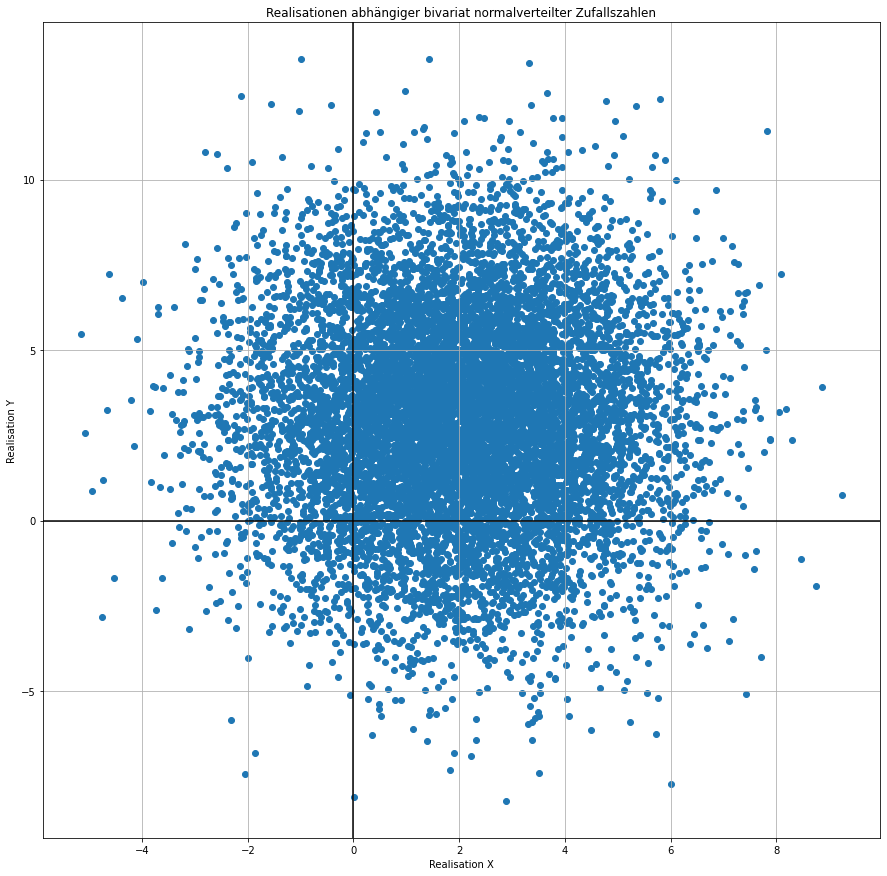

In [9]:
x_liste, y_liste = split_liste(total_standard_norm_ab_list) # X- und Y-Realisationen aus gemeinsamer Liste extrahieren
plt.title('Realisationen abhängiger bivariat normalverteilter Zufallszahlen') # Spezifischer Titel
plot_func(x_liste, y_liste, show=True, get_xy_lim=True) # Plot erzeugen und anzeigen

## Realisationen Gauss-Copula
Darstellung der Abhänigkeitsstruktur ohne die (alten) Randverteilungen.
Diese Realisationen lassen sich als Wahrscheinlichkeiten interpretieren.

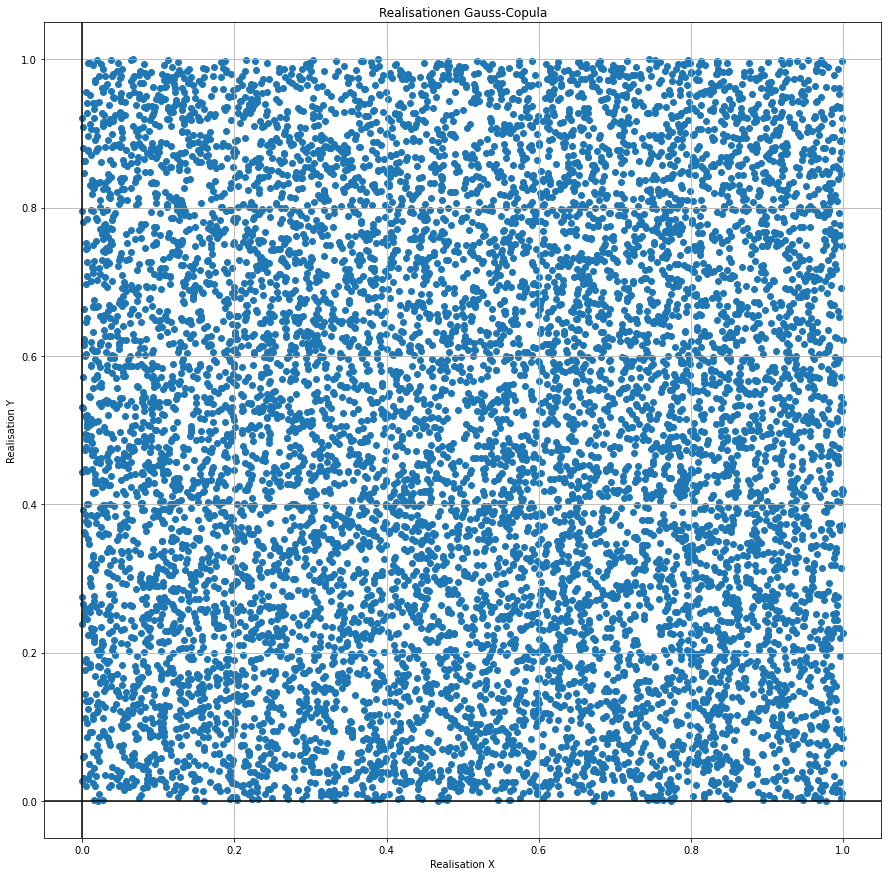

In [10]:
x_liste, y_liste = split_liste(total_realisation_cop_list) # X- und Y-Realisationen aus gemeinsamer Liste extrahieren
plt.title('Realisationen Gauss-Copula') # Spezifischer Titel
plot_func(x_liste, y_liste, show=True, get_xy_lim=True) # Plot erzeugen und anzeigen

## Realisationen gleichverteilte X, Y mit Gauss-Copula
Die Abhängikeitsstruktur wurde auf die neuen Randverteilungen übertragen.  
Die Realisationen sind auf das Intervall $[18,42]$ beschränkt (siehe rand_y, rand_y), da dies die gemeinsame Ober- bzw. Untergrenze der vorgegebenen neuen Randverteilungen ist.

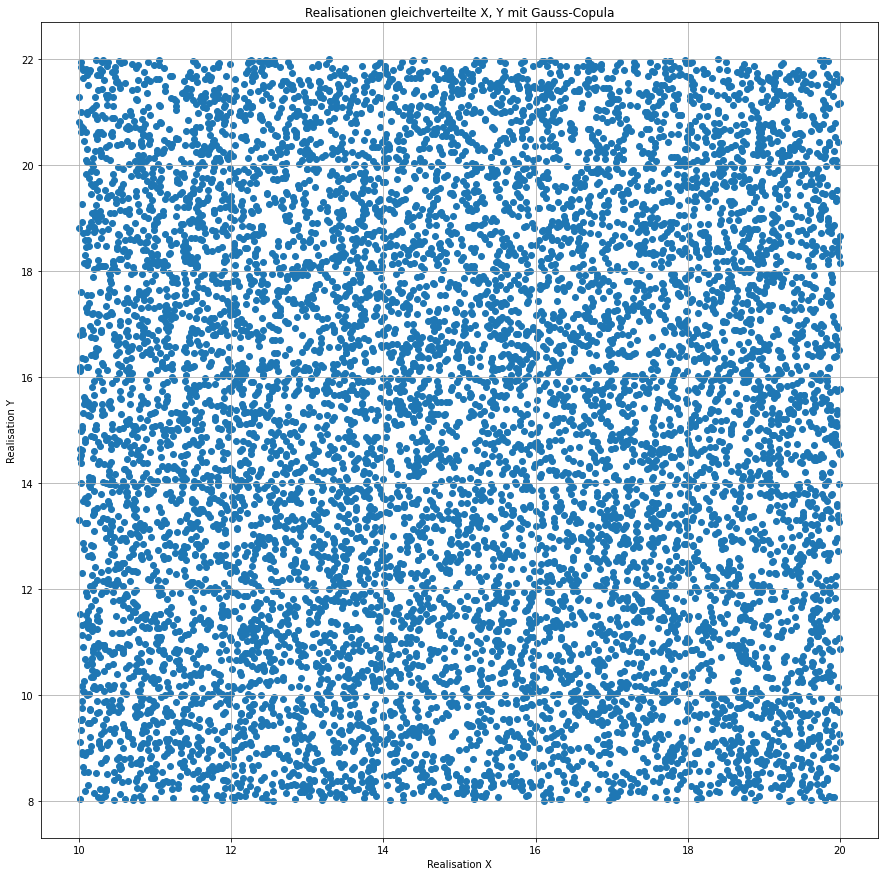

In [11]:
x_liste, y_liste = split_liste(total_xy_list) # X- und Y-Realisationen aus gemeinsamer Liste extrahieren
plt.title('Realisationen gleichverteilte X, Y mit Gauss-Copula') # Spezifischer Titel
plot_func(x_liste, y_liste, show=True, get_xy_lim=True) # Plot erzeugen und anzeigen

## Histogramm X+Y, Realisationen gleichverteilte X, Y mit Gauss-Copula
Darstellung der Simulationsergebnisse als Summe der $x$ und $y$ Realisationen unter Berücksichtung Abhänigkeitsstruktur und neuen Randverteilungen.
Es zeigt sich ein auf das Intervall $[18,42]$ beschränkter glockenförmiger Verlauf, wie er für eine Normalverteilung üblich ist.
<br>
Hinweis: Obige Aussage gilt nur bei einem Korrelationskoeffizienten von $0$.

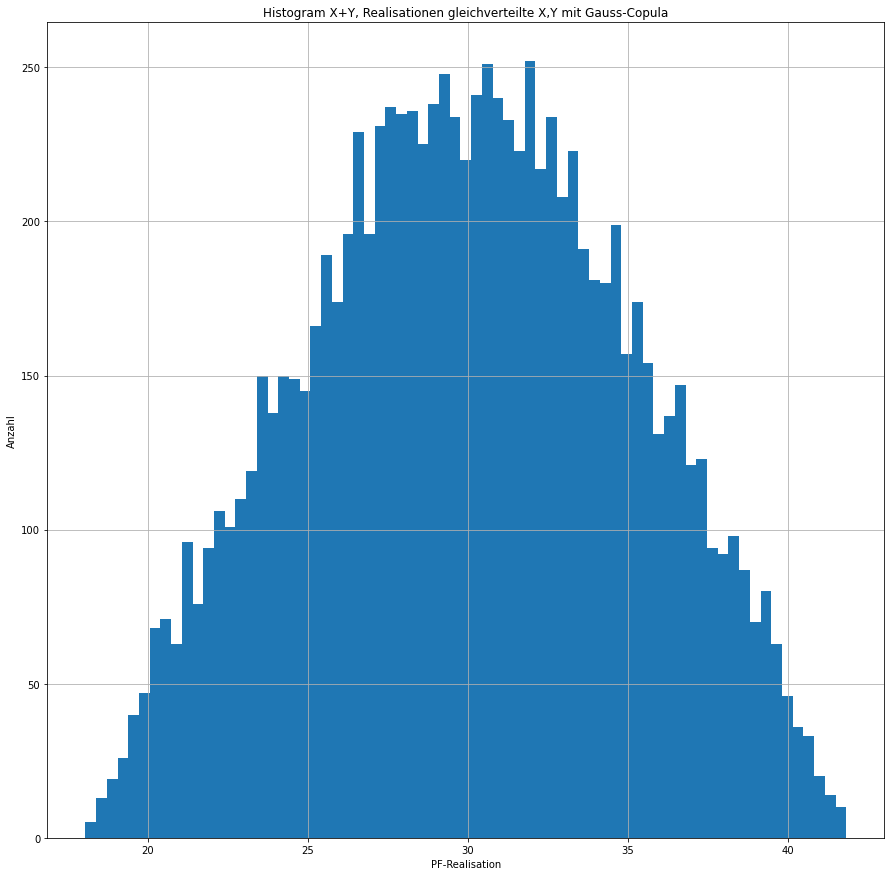

In [12]:
bins = 71
data = total_summe_liste
plt.hist(data, bins=bins)
plt.grid()
plt.title('Histogram X+Y, Realisationen gleichverteilte X,Y mit Gauss-Copula')
plt.xlabel('PF-Realisation')
plt.ylabel('Anzahl')
plt.show()

## Verteilung X+Y, Realisationen gleichverteilte X, Y mit Gauss-Copula
Darstellung der resultierenden kumulativen Verteilungsfunktion. 
Diese nimmt, wie für eine Normalverteilung üblich, einen S-förmigen Verlauf.

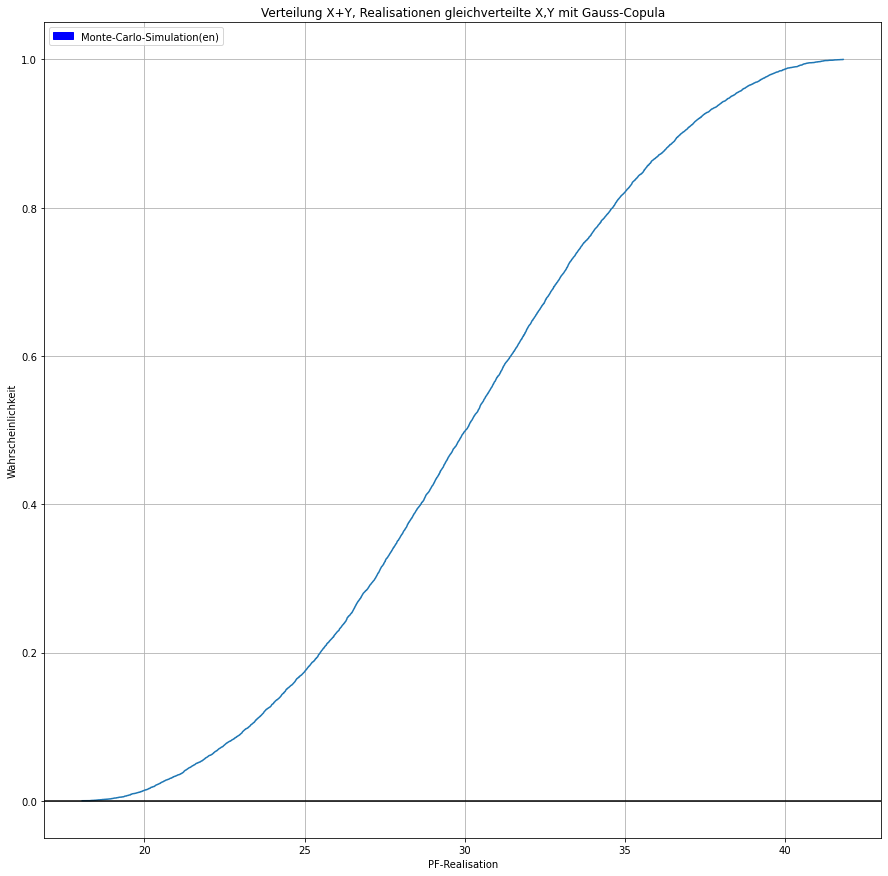

In [13]:
H, X1 = np.histogram(total_summe_liste, bins=n, density=True)
hist_func(H, X1)
verteilung_func()

## Risikomaße schätzen:

### Parameterfestlegung und Aufruf der Funktionen

In [14]:
#---------------------------
# Nutzung der objektorientierten Programmierung 
x = rm(total_summe_liste, alpha=0.1, gamma=0.5)

#---------------------------
# Value at Risk
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Der VaR beträgt: ' + str(x.VaR()) + '.') + '| ')

#---------------------------
# Conditional Value at Risk
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Der CVaR beträgt: ' + str(x.CVaR()) + '.') + '| ')

#---------------------------
# Power-Spektrales Risikomaß
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Power-Spektrales Risikomaß bei der Monte-Carlo-Simulation:') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Der Erwartungswert beträgt: ' + str(x.expected_value) + '.') + '| ')
print('|' + centered('Das Risiko beträgt: ' + str(x.Power()) + '.') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')

#-------------------------------------------------------------------------------------------------------------------#
|                                        Der VaR beträgt: -23.26850397077635.                                       | 
#-------------------------------------------------------------------------------------------------------------------#
|                                       Der CVaR beträgt: -21.463530631916644.                                      | 
#-------------------------------------------------------------------------------------------------------------------#
|                             Power-Spektrales Risikomaß bei der Monte-Carlo-Simulation:                            | 
#-------------------------------------------------------------------------------------------------------------------#
|                                  Der Erwartungswert beträgt: 30.023678821951652.                                  | 
|                                       Das Risiko b

## "Instabilität" Monte-Carlo-Simulation
Ein Kritikpunkt an der Monte-Carlo-Simulation ist, dass das Ergebnis des Verfahrens großen Schwankungen unterliegen kann, sofern nur wenige Realisationen in einem Simulationslauf simuliert werden.
Dies soll die folgende Grafik veranschaulichen.
Dabei kann sowohl die Anzahl der Simulationsläufe als auch die Anzahl der in jeder Simulation durchgeführten Simulationen variiert werden.

#-------------------------------------------------------------------------------------------------------------------#
|   [INFO] Der DataFrame mit den auf den auf 10 mal 100 Durchläufen beruhenden Risikomaßen ergibt sich wie folgt:   | 
#-------------------------------------------------------------------------------------------------------------------#
         VaR  VaR-Change       CVaR  CVaR-Change      Power  Power-Change
0 -22.273417         NaN -20.689489          NaN  26.432191           NaN
1 -22.296422    0.001033 -21.247882     0.026989  26.919488      0.018436
2 -24.187101    0.084797 -22.831485     0.074530  27.075512      0.005796
3 -23.267101   -0.038037 -21.526994    -0.057136  26.995261     -0.002964
4 -24.781697    0.065096 -22.154959     0.029171  27.317715      0.011945
5 -24.086511   -0.028052 -22.664850     0.023015  27.381248      0.002326
6 -21.964021   -0.088119 -20.990603    -0.073870  26.298135     -0.039557
7 -24.758845    0.127246 -22.643102     0.078726  27.

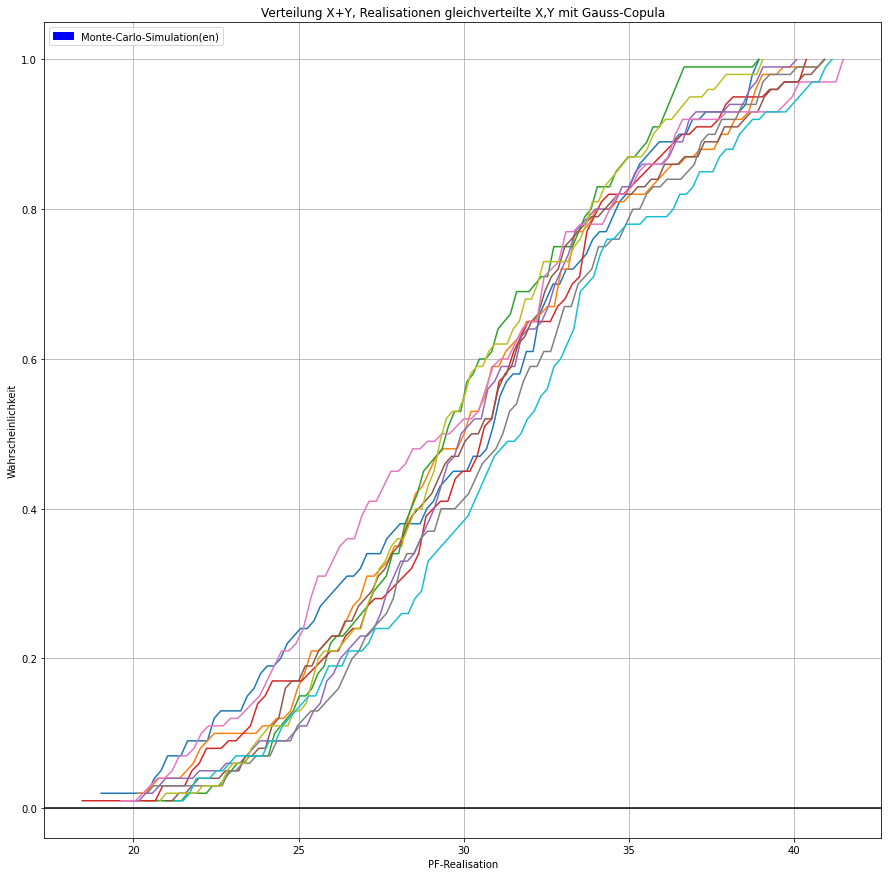

In [15]:
##########################################################################
#-------------------------------------------------------------------------
# Parameter Risikomaße
alpha = 0.1
gamma = 0.5

#-------------------------------------------------------------------------
# Wiederholungen der Simulationen
runs_sim = 100 # Legt die Anzahl der Durchläufe einer Simulation fest
runs_func = 10 # Legt fest, wie viele Simulationen durchgeführt werden

#-------------------------------------------------------------------------
##########################################################################

RM_VaR_list, RM_CVaR_list = [], []
RM_PSRM_list, mega_summe_list = [], []

# Führe die Simulation "runs_func mal" durch und speichere die Ergebnisse in der jeweiligen Liste
for i in range(0, runs_func):
    _, _, _, total_summe_liste = copula_sim(runs_sim, rand_x, rand_y, mu, std_list, corr_list, full_log=False)
    mega_summe_list += total_summe_liste
    x = rm(total_summe_liste, alpha, gamma)    
    RM_VaR_list.append(x.VaR())    
    RM_CVaR_list.append(x.CVaR())
    RM_PSRM_list.append(x.Power())

#---------------------------
# Erzeuge ein DataFrame mit den Simulationsvergebnissen
# und deren prozentualen Änderung vom jeweils vorherigen Ergebnis
RM_frame = pd.DataFrame()
RM_frame['VaR'] = RM_VaR_list
RM_frame['VaR-Change'] = RM_frame['VaR'].pct_change()
RM_frame['CVaR'] = RM_CVaR_list
RM_frame['CVaR-Change'] = RM_frame['CVaR'].pct_change()
RM_frame['Power'] = RM_PSRM_list
RM_frame['Power-Change'] = RM_frame['Power'].pct_change()

#---------------------------
# Ermittle die kleinste und größte Relaisation des jweiligen Risikomaßes
Min_Max_VaR = (min(RM_VaR_list), max(RM_VaR_list))
Min_Max_CVaR = (min(RM_CVaR_list), max(RM_CVaR_list))
Min_Max_PSRM = (min(RM_PSRM_list), max(RM_PSRM_list))

#---------------------------
# Gib den DataFrame und die Infos zurück
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('[INFO] Der DataFrame mit den auf den auf ' +str(runs_func) + ' mal ' + str(runs_sim) + ' Durchläufen beruhenden Risikomaßen ergibt sich wie folgt: ') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')
print(RM_frame)
print('#' + SCREEN_WIDTH * '-' + '#')
print('|' + centered('Nach ' + str(runs_func) + ' Simulationsläufen mit je ' + str(runs_sim) + ' Durchläufen beträgt der kleinste VaR ' + str(round(Min_Max_VaR[0],2)) +', der größte ' + str(round(Min_Max_VaR[1],2)) + ' (\u0394 = ' + str((round((float(Min_Max_VaR[0]/Min_Max_VaR[1])-1)*100,2))) + '%).') + '| ')
print('|' + centered('Nach ' + str(runs_func) + ' Simulationsläufen mit je ' + str(runs_sim) + ' Durchläufen beträgt der kleinste CVaR ' + str(round(Min_Max_CVaR[0],2)) +', der größte ' + str(round(Min_Max_CVaR[1],2)) + ' (\u0394 = ' + str((round((float(Min_Max_CVaR[0]/Min_Max_CVaR[1])-1)*100,2))) + '%).') + '| ')
print('|' + centered('Nach ' + str(runs_func) + ' Simulationsläufen mit je ' + str(runs_sim) + ' Durchläufen beträgt das kleinste P-SRM ' + str(round(Min_Max_PSRM[0],2)) +', das größte ' + str(round(Min_Max_PSRM[1],2)) + ' (\u0394 = ' + str((round((float(Min_Max_PSRM[0]/Min_Max_PSRM[1])-1)*100,2))) + '%).') + '| ')
print('#' + SCREEN_WIDTH * '-' + '#')

#-------------------------------------------
# Zerlege die mega_summe_list (beinhaltet alle Ergenisse) in Teillisten,
# welche die Ergebnisse der einzelnen Simulationsläufe beinhalten
counter_0, counter_1 = 0, runs_sim
array = []
for i in range(0, runs_func):
    x = mega_summe_list[counter_0:counter_1]
    array.append(x)
    counter_0 += runs_sim
    counter_1 += runs_sim

#---------------------------
# Erstelle für jedes Dieser Teillisten ein Histogramm
# und plotte anschlißend das Ergebnis
for items in array:
    values_PF = items
    bins = runs_sim    
    H, X1 = np.histogram(values_PF, bins, density=True)
    hist_func(H, X1)
verteilung_func()